In [1]:
%pip install missingno
import missingno

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix, log_loss, plot_roc_curve, auc, precision_recall_curve
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression




## Preliminary Data Processing
To start off, we read in our dataset and generate a simple preview and statistics of our data.

In [3]:
df_train = pd.read_csv('aug_train.csv')
df_test = pd.read_csv('aug_test.csv')

df_train.info()
df_train.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0
5,21651,city_176,0.764,NaN,Has relevent experience,Part time course,Graduate,STEM,11,NaN,NaN,1,24,1.0
6,28806,city_160,0.920,Male,Has relevent experience,no_enrollment,High School,NaN,5,50-99,Funded Startup,1,24,0.0
7,402,city_46,0.762,Male,Has relevent experience,no_enrollment,Graduate,STEM,13,<10,Pvt Ltd,>4,18,1.0
8,27107,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,7,50-99,Pvt Ltd,1,46,1.0
9,699,city_103,0.920,NaN,Has relevent experience,no_enrollment,Graduate,STEM,17,10000+,Pvt Ltd,>4,123,0.0


In [4]:
df_train["experience"].value_counts()

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [5]:
# The output shows that we have 19158 entries and 13 columns.
# Zero null values but some of the columns’ data type should be changed: float64(2), int64(2), object(10)

In [6]:
for col in df_train.columns:
    print(df_train[col].value_counts())

2047     1
2692     1
4743     1
27272    1
25225    1
        ..
17682    1
19731    1
29972    1
25878    1
6147     1
Name: enrollee_id, Length: 19158, dtype: int64
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
            ... 
city_111       3
city_129       3
city_121       3
city_140       1
city_171       1
Name: city, Length: 123, dtype: int64
0.920    5200
0.624    2702
0.910    1533
0.926    1336
0.698     683
         ... 
0.649       4
0.807       4
0.781       3
0.625       3
0.664       1
Name: city_development_index, Length: 93, dtype: int64
Male      13221
Female     1238
Other       191
Name: gender, dtype: int64
Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64
no_enrollment       13817
Full time course     3757
Part time course     1198
Name: enrolled_university, dtype: int64
Graduate          11598
Masters            4361
High School        2017
Phd                 414
Pri

 Features
 
 Find out the values of the categorical variables
 
 Categorical variables/features are any feature type can be classified into two major types:

- Nominal
Nominal variables are variables that have two or more categories which do not have any kind of order associated with them. For example, if gender is classified into two groups, i.e. male and female, it can be considered as a nominal variable.

- Ordinal
Ordinal variables on the other hand, have “levels” or categories with a particular order associated with them. For example, an ordinal categorical variable can be a feature with three different levels: low, medium and high. Order is important.
 
 
 
 0   enrollee_id             int64  --> Unique ID for enrollee
 1   city                    object ->  City Code
 2   city_development_index  float64
 3   gender                  object -> categorical (male, female or other) --> set 0 / 1 / 2
 4   relevent_experience     object -> categorical (has relevant experience or not)  --> set 0 / 1
 5   enrolled_university     object -> categorical (full-time, part-time, not enrolled)  
 6   education_level         object -> categorical (Graduate, Masters, High school, Phd, Primary Schhool)  
 7   major_discipline        object -> categorical (STEM, Business Degree, Humanities, Other, Arts, No Major )  
 8   experience              object -> categorical (<1 ... >20) --> groupby
 9   company_size            object -> categorical (<10, ..., 5000-9999)
 10  company_type            object -> categorical (Pvt Ltd, Funded Startup, Public Sector, Early Stage Startup, NGO, Other)
 11  last_new_job            object -> categorical (never (--> set 0), ...>4)
 12  training_hours          int64  -> training hours completed
 13  target                  float64 -> 0 – Not looking for job change, 1 – Looking for a job change

Various Approaches to Encode Categorical Features

Label Encoding refers to converting the labels into numeric form so as to convert it into the machine-readable form. Machine learning algorithms can then decide in a better way on how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

We can do label Encoding From LabelEncoder of scikit-Learn but to do so first we have to impute missing values in data

# Missing values and Duplicated Entries

In [9]:
df_train.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64


Preview of data with null values:
xxxxxxxxxxxxx
   enrollee_id      city  city_development_index gender  \
0         8949  city_103                   0.920   Male   
2        11561   city_21                   0.624    NaN   
3        33241  city_115                   0.789    NaN   

       relevent_experience enrolled_university education_level  \
0  Has relevent experience       no_enrollment        Graduate   
2   No relevent experience    Full time course        Graduate   
3   No relevent experience                 NaN        Graduate   

  major_discipline experience company_size company_type last_new_job  \
0             STEM        >20          NaN          NaN            1   
2             STEM          5          NaN          NaN        never   
3  Business Degree         <1          NaN      Pvt Ltd        never   

   training_hours  target  
0              36     1.0  
2              83     0.0  
3              52     1.0  


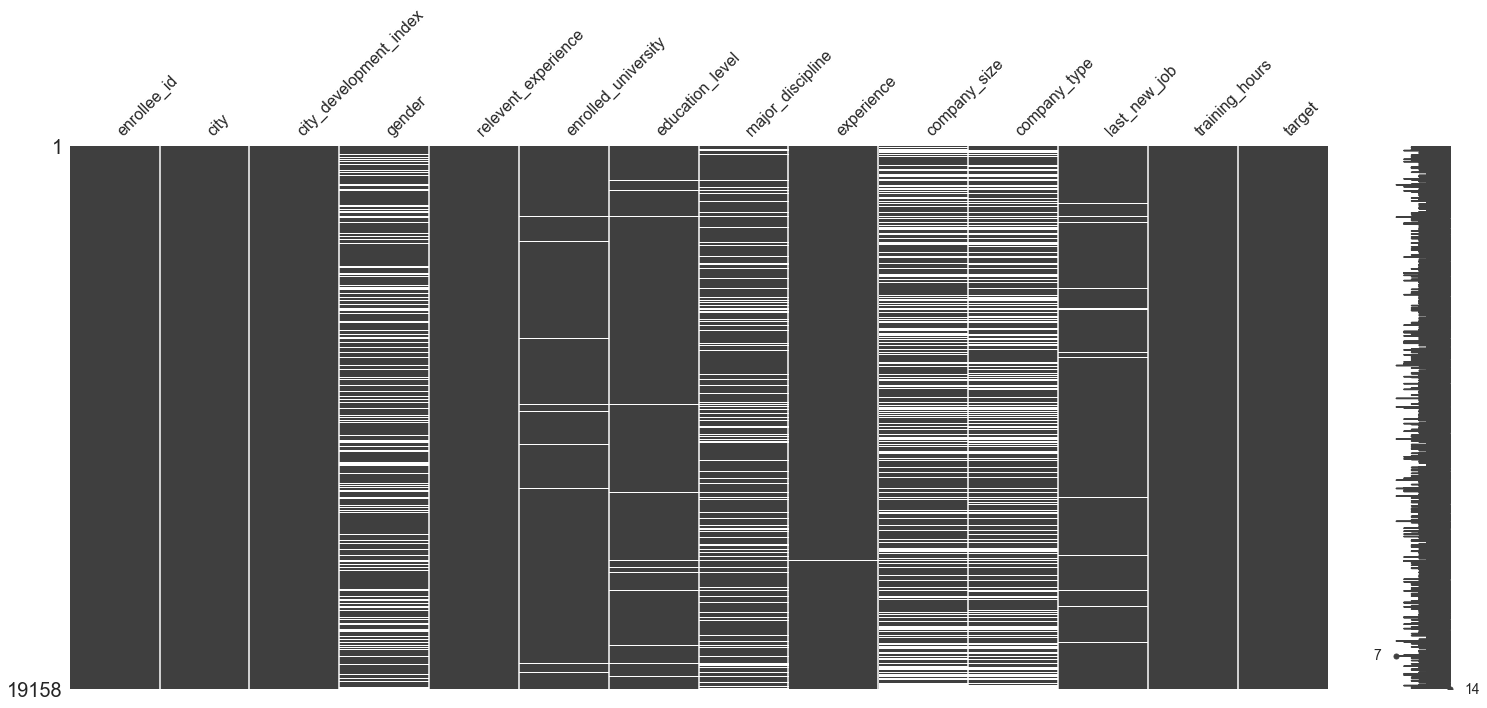

In [10]:
# generate preview of entries with null values

if df_train.isnull().any(axis=None):
    print("\nPreview of data with null values:\nxxxxxxxxxxxxx")
    print(df_train[df_train.isnull().any(axis=1)].head(3))
    missingno.matrix(df_train)
    plt.show()

In [11]:
# generate count statistics of duplicate 

if len(df_train[df_train.duplicated()]) > 0:
    print("No. of duplicated entries: ", len(df_train[df_train.duplicated()]))
    print(df_train[df_train.duplicated(keep=False)].sort_values(by=list(df.columns)).head())
else:
    print("No duplicated entries found")

No duplicated entries found


In [ ]:
# In our case, there are also no duplicated entries, which the code will point out directly by printing the output “No duplicated entries found”.
# In the event of duplicated entries, the output will show the number of duplicated entries and a preview of these entries.
# For duplicated entries, check that they are indeed duplicated and drop them by the following code.
# df.drop_duplicates(inplace=True)

In [ ]:
# In case of any missing values or duplicated entries, you should decide on the cleaning steps required before proceeding further to the other parts of EDA.

Especially for the features (Gender, Major_Discipline, Company_Size, Company_Type), we see that 75% of the data is missing. If there is a lower percentage, we have a chance of treating the missing values but with way more than half of the values missing, we cannot work with that column.

It is always good to be able to use some domain knowledge when analysing your dataset. Our goal now is to find out the best predictors for who will move to a new job.

# Filling in missing values of a column


In [12]:
from sklearn.preprocessing import LabelEncoder

#Making Copy of data just for example
df_lb = df_train.copy()
df_lb['education_level'].value_counts()

Graduate          11598
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [13]:

#Fill nan values
df_lb.loc[:, "education_level"] = df_lb['education_level'].fillna("NONE")

# initialize LabelEncoder
lbl_enc = LabelEncoder()

# fit label encoder and transform values on ord_2 column
df_lb.loc[:, "education_level"] = lbl_enc.fit_transform(df_lb['education_level'].values)

df_lb['education_level'].value_counts()

0    11598
2     4361
1     2017
3      460
4      414
5      308
Name: education_level, dtype: int64

The feature column education_level of data is now transformed into numarical form as we can see above

But in this Notebook i am not going to use scikit-Learn LabelEncoder Due to following reasons

Label Encoder encode data on basis of count but as mentioned above this data have lots of ordinal features means categories of some features might depend upon some levels like in education_level feature\

We know that we should encode data in this order but label encoder encodes it on basis of count

Primary School
High School
Graduate
Masters
Phd

To use label encoder first we have to create NULL values as new category and Our data have so many NULL values so we can not just create new Category for NULL values because due to this data distribution could change

In [14]:
# Another approach would be to create a dictonary, define the new numerical categories and then map it to the columns
# 1) Making Dictionaries of ordinal features

gender_map = {
        'Female': 2,
        'Male': 1,
        'Other': 0
         }

relevent_experience_map = {
    'Has relevent experience':  1,
    'No relevent experience':    0
}

enrolled_university_map = {
    'no_enrollment'   :  0,
    'Full time course':    1, 
    'Part time course':    2 
}
    
education_level_map = {
    'Primary School' :    0,
    'Graduate'       :    2,
    'Masters'        :    3, 
    'High School'    :    1, 
    'Phd'            :    4
    } 
    
major_map ={ 
    'STEM'                   :    0,
    'Business Degree'        :    1, 
    'Arts'                   :    2, 
    'Humanities'             :    3, 
    'No Major'               :    4, 
    'Other'                  :    5 
}
    
experience_map = {
    '<1'      :    0,
    '1'       :    1, 
    '2'       :    2, 
    '3'       :    3, 
    '4'       :    4, 
    '5'       :    5,
    '6'       :    6,
    '7'       :    7,
    '8'       :    8, 
    '9'       :    9, 
    '10'      :    10, 
    '11'      :    11,
    '12'      :    12,
    '13'      :    13, 
    '14'      :    14, 
    '15'      :    15, 
    '16'      :    16,
    '17'      :    17,
    '18'      :    18,
    '19'      :    19, 
    '20'      :    20, 
    '>20'     :    21
} 
    
company_type_map = {
    'Pvt Ltd'               :    0,
    'Funded Startup'        :    1, 
    'Early Stage Startup'   :    2, 
    'Other'                 :    3, 
    'Public Sector'         :    4, 
    'NGO'                   :    5
}

company_size_map = {
    '<10'          :    0,
    '10/49'        :    1, 
    '100-500'      :    2, 
    '1000-4999'    :    3, 
    '10000+'       :    4, 
    '50-99'        :    5, 
    '500-999'      :    6, 
    '5000-9999'    :    7
}
    
last_new_job_map = {
    'never'        :    0,
    '1'            :    1, 
    '2'            :    2, 
    '3'            :    3, 
    '4'            :    4, 
    '>4'           :    5
}

In [15]:
# 2) using the map function to transform categorical features into numarical features
# Transforming Categorical features into numarical features

df_train.loc[:,'education_level'] = df_train['education_level'].map(education_level_map)
df_train.loc[:,'company_size'] = df_train['company_size'].map(company_size_map)
df_train.loc[:,'company_type'] = df_train['company_type'].map(company_type_map)
df_train.loc[:,'last_new_job'] = df_train['last_new_job'].map(last_new_job_map)
df_train.loc[:,'major_discipline'] = df_train['major_discipline'].map(major_map)
df_train.loc[:,'enrolled_university'] = df_train['enrolled_university'].map(enrolled_university_map)
df_train.loc[:,'relevent_experience'] = df_train['relevent_experience'].map(relevent_experience_map)
df_train.loc[:,'gender'] = df_train['gender'].map(gender_map)
df_train.loc[:,'experience'] = df_train['experience'].map(experience_map)

#encoding city feature using label encoder
lb_en = LabelEncoder()

df_train.loc[:,'city'] = lb_en.fit_transform(df_train.loc[:,'city']) 

In [16]:
df_train.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,5,0.920,1.0,1,0.0,2.0,0.0,21.0,NaN,NaN,1.0,36,1.0
1,29725,77,0.776,1.0,0,0.0,2.0,0.0,15.0,5.0,0.0,5.0,47,0.0
2,11561,64,0.624,NaN,0,1.0,2.0,0.0,5.0,NaN,NaN,0.0,83,0.0
3,33241,14,0.789,NaN,0,NaN,2.0,1.0,0.0,NaN,0.0,0.0,52,1.0
4,666,50,0.767,1.0,1,0.0,3.0,0.0,21.0,5.0,1.0,4.0,8,0.0


Various Approaches to Handle Missing values in Categorical Features 

1) You can simply drop columns having very large amount of null values
2) Drop entire row if it has some null values (But this approach is not Recommendable because then we will lose lots of precious data)
3) First convert none null categorical data into numarical form and then simply fill mean, mode or median value inplace of null values
4) First convert none null categorical data into numarical form and then with the help of k-Nearest Neighbors algorithm find missing values and impute them in data
5) Another way of imputing missing values in a column would be to train a regression model that tries to predict missing values in a column based on other columns.

In [ ]:
df_train['gender'] = df_train['gender'].fillna((df_train['gender'].mean()))
df_train['enrolled_university'] = df_train['enrolled_university'].fillna((df_train['enrolled_university'].mean()))
df_train['major_discipline'] = df_train['major_discipline'].fillna((df_train['major_discipline'].mean()))
df_train['company_size'] = df_train['company_size'].fillna((df_train['company_size'].mean()))
df_train['company_type'] = df_train['company_type'].fillna((df_train['company_type'].mean()))
df_train['company_type'] = df_train['company_type'].fillna((df_train['company_type'].mean()))

In [ ]:
# set identifier "enrollee_id" as index
df_train['enrollee_id'] = df_train['enrollee_id'].astype('index')


# set categorical data
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')
df_train['Open'] = df['Open'].astype('category')
df_train['Promo'] = df_train['Promo'].astype('category')
df_train['StateHoliday'] = df_train['StateHoliday'].astype(str).str.strip().astype('category')
df_train['SchoolHoliday'] = df_train['SchoolHoliday'].astype('category')


# Categorical Data EDA
Our main EDA objective for categorical data is to know the unique values and their corresponding count.

In [ ]:
#The function generating the EDA for categorical data is categorical_eda.

def categorical_eda(df):
    """Given dataframe, generate EDA of categorical data"""
    print("To check: Unique count of non-numeric data")
    print(df_train.select_dtypes(include=['category']).nunique())
    top5(df)
    # Plot count distribution of categorical data
    for col in df_train.select_dtypes(include='category').columns:
        fig = sns.catplot(x=col, kind="count", data=df_train)
        fig.set_xticklabels(rotation=90)
        plt.show()

# Numeric Data EDA
For numeric data, our EDA approach is as follows:
- Plot univariate distribution of each numeric data
- If categorical data are available, plot univariate distribution by each categorical value
- Plot pairwise joint distribution of numeric data